In [1]:

import os
import torch as t
from utils.config import opt
# from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from model.faster_rcnn_resnet50 import FasterRCNN_ResNet50
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils import array_tool as at
from matplotlib import pyplot as plot
import numpy as np
%matplotlib inline

In [2]:
VOC_BBOX_LABEL_NAMES = (
    'fly',
    'bike',
    'bird',
    'boat',
    'pin',
    'bus',
    'c',
    'cat',
    'chair',
    'cow',
    'table',
    'dog',
    'horse',
    'moto',
    'p',
    'plant',
    'shep',
    'sofa',
    'train',
    'tv',
)

In [3]:
def vis_image(img, ax=None):
    """Visualize a color image.

    Args:
        img (~numpy.ndarray): An array of shape :math:`(3, height, width)`.
            This is in RGB format and the range of its value is
            :math:`[0, 255]`.
        ax (matplotlib.axes.Axis): The visualization is displayed on this
            axis. If this is :obj:`None` (default), a new axis is created.

    Returns:
        ~matploblib.axes.Axes:
        Returns the Axes object with the plot for further tweaking.

    """

    if ax is None:
        fig = plot.figure()
        ax = fig.add_subplot(1, 1, 1)
    # CHW -> HWC
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))
    return ax


def vis_bbox(img, bbox, label=None, score=None, ax=None):
    """Visualize bounding boxes inside image.

    Args:
        img (~numpy.ndarray): An array of shape :math:`(3, height, width)`.
            This is in RGB format and the range of its value is
            :math:`[0, 255]`.
        bbox (~numpy.ndarray): An array of shape :math:`(R, 4)`, where
            :math:`R` is the number of bounding boxes in the image.
            Each element is organized
            by :math:`(y_{min}, x_{min}, y_{max}, x_{max})` in the second axis.
        label (~numpy.ndarray): An integer array of shape :math:`(R,)`.
            The values correspond to id for label names stored in
            :obj:`label_names`. This is optional.
        score (~numpy.ndarray): A float array of shape :math:`(R,)`.
             Each value indicates how confident the prediction is.
             This is optional.
        label_names (iterable of strings): Name of labels ordered according
            to label ids. If this is :obj:`None`, labels will be skipped.
        ax (matplotlib.axes.Axis): The visualization is displayed on this
            axis. If this is :obj:`None` (default), a new axis is created.

    Returns:
        ~matploblib.axes.Axes:
        Returns the Axes object with the plot for further tweaking.

    """

    label_names = list(VOC_BBOX_LABEL_NAMES) + ['bg']
    # add for index `-1`
    if label is not None and not len(bbox) == len(label):
        raise ValueError('The length of label must be same as that of bbox')
    if score is not None and not len(bbox) == len(score):
        raise ValueError('The length of score must be same as that of bbox')

    # Returns newly instantiated matplotlib.axes.Axes object if ax is None
    ax = vis_image(img, ax=ax)

    # If there is no bounding box to display, visualize the image and exit.
    if len(bbox) == 0:
        return ax

    for i, bb in enumerate(bbox):
        xy = (bb[1], bb[0])
        height = bb[2] - bb[0]
        width = bb[3] - bb[1]
        ax.add_patch(plot.Rectangle(
            xy, width, height, fill=False, edgecolor='red', linewidth=2))

        caption = list()

        if label is not None and label_names is not None:
            lb = label[i]
            if not (-1 <= lb < len(label_names)):  # modfy here to add backgroud
                raise ValueError('No corresponding name is given')
            caption.append(label_names[lb])
        if score is not None:
            sc = score[i]
            caption.append('{:.2f}'.format(sc))

        if len(caption) > 0:
            ax.text(bb[1], bb[0],
                    ': '.join(caption),
                    style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    return ax

In [7]:
img = read_image('demo-sample.jpg')
img = t.from_numpy(img)[None]

In [8]:
faster_rcnn = FasterRCNN_ResNet50()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# 2. model trained with torchvision pretrained model

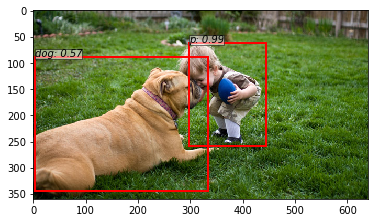

In [9]:
trainer.load('./checkpoints/fasterrcnn_07031445_0.7611494152696302')
opt.caffe_pretrain=False # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it